# Завдання

- Отримати базові навички роботи з нейронними мережами.
- Отримати досвід вирішення проблеми класифікації зображень.
- Удосконалити агента-автомобіля з попередньої лабораторної роботи.

# Опис роботи

Усе починається зі створення CNN моделі, навчання її та використання її для отримання значень.

1. На початку йде завантаження датасету та його обробка, а саме: перетворення у тип **float32**, зміна **розмірів** відповідно до моделі.
2. Створення CNN моделі, яка складається з: шару 2D згортки, шару нормалізації вхідних даних, рівня об’єднання для 2D-вхідних даних та, окрім вихідних шарів, згладжувальний рівень.
3. Після цього йде навчання моделі та візуальне відображення роботи моделі: графіки точності та втрат й картинки з підписами реальної та вгаданої цифр.

У самому графі є метод, який випадково обирає цифри(обмеження швидкості). Я запам'ятовую цифру та індекс цієї цифри серед картинок:

```python
def __create_limitations(self):
    self.limitations: Dict[tuple, list] = {}
    for edge in self.G.edges:
        limitation = 1
        random_index = 0
        while 0 <= limitation <= 1:
            random_index = randint(0, len(train_images)-1)
            limitation = np.argmax(train_labels[random_index])
        self.limitations[edge] = [random_index, limitation]
```

При цьому є метод, де по індексу береться картинка, та розпізнається цифри за допомогою моделі:
```python
def __add_limitation_to_history(self, start, end):
    index = 0
    try:
        index = self.limitations[start, end][0]
    except KeyError:
        index = self.limitations[end, start][0]
    predicted_value = network.predict(train_images[index].reshape(1, 28, 28, 1))
    self.limitations_history.append(np.argmax(predicted_value) * 10)
```

І у підсумку розпізнані цифри виводяться разом з історією:

```
History:  [0, 4, 8, 9, 10, 11, 15]
Speed limitations:  [80, 60, 20, 40, 90, 90]
You have ended the walk
```

# Виконання

In [130]:
from typing import List, Dict
from random import choice
from copy import deepcopy
from math import sqrt
from random import randint

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from keras import models, layers
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import load_model

### Нейронна мережа

#### Отримання даних

In [131]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [132]:
len(train_images)

60000

In [133]:
len(test_images)

10000

In [134]:
random_index = randint(0, len(train_images))
random_index

55048

Text(0.5, 1.0, '0')

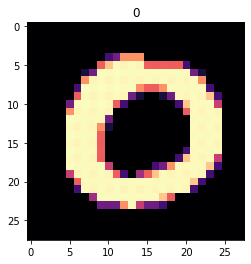

In [135]:
plt.imshow(train_images[random_index], cmap=plt.get_cmap('magma'))
plt.title(train_labels[random_index])

#### Обробка даних

In [136]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [137]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [138]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

`to_categorical` дає представлення чисел у вигляді масиву, у якому стоїть найбільше значення на індексі, що відповідає числу.

```python
2 = [0,0,1,0,0,0,0,0,0,0]
3 = [0,0,0,1,0,0,0,0,0,0]
```

#### Створення моделі

In [139]:
network = models.Sequential()

In [140]:
network.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
network.add(layers.BatchNormalization())
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
network.add(layers.BatchNormalization())
network.add(layers.Dense(10, activation='softmax'))

In [141]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 batch_normalization_3 (Batc  (None, 100)             

In [142]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Тренування моделі

In [143]:
history = network.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 46s 97ms/step - loss: 0.1194 - accuracy: 0.9649 - val_loss: 0.1036 - val_accuracy: 0.9712
Epoch 2/10
469/469 [==============================] - 45s 97ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.0511 - val_accuracy: 0.9831
Epoch 3/10
469/469 [==============================] - 45s 95ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0497 - val_accuracy: 0.9841
Epoch 4/10
469/469 [==============================] - 47s 101ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.0484 - val_accuracy: 0.9860
Epoch 5/10
469/469 [==============================] - 46s 98ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0483 - val_accuracy: 0.9873
Epoch 6/10
469/469 [==============================] - 45s 97ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0494 - val_accuracy: 0.9869
Epoch 7/10
469/469 [==============================] - 44s 95ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0619 - val_accuracy

In [144]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

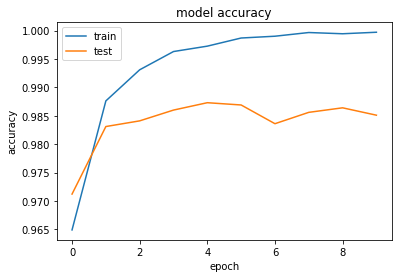

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

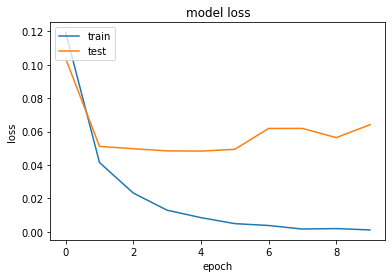

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [147]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 11ms/step - loss: 0.0641 - accuracy: 0.9851


In [148]:
predicted_labels = network.predict(test_images)

313/313 [==============================] - 3s 10ms/step


In [149]:
random_index = randint(0, len(test_images)-9)
random_index

1571

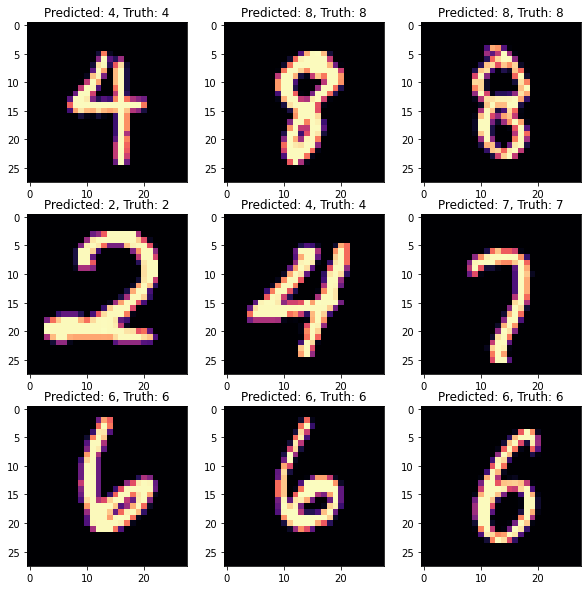

In [150]:
plt.figure(figsize=(10,10))
for image_index, plot_image in zip(range(random_index, random_index+9), range(9)):
  # print(f'{np.argmax(predicted_labels[index])}, {np.argmax(test_labels[index])}')
  plt.subplot(3,3,plot_image+1)
  plt.imshow(test_images[image_index].reshape(28,28), cmap='magma', interpolation='none')
  plt.title(f"Predicted: {np.argmax(predicted_labels[image_index])}, Truth: {np.argmax(test_labels[image_index])}")

In [151]:
network.save('model.h5')

### Робота графа

In [152]:
class Graph:
    shift = (0.1, 0.1)

    def __init__(self, n: int = 5):
        self.double_n = n * n
        self.n = n
        self.edgesList: List[list] = [[] for _ in range(self.double_n)]
        self.edges_n = 0
        self._create_edges()
        self.__make_graph()
        self.__create_limitations()
        self.active_node = 0
        self.history = []
        self.limitations_history = []
        self.good_nodes = []

    def _create_edges(self): 
        for start in range(self.double_n):
            for end in range(self.double_n):
                if abs(end - start) == self.n:
                    self.edgesList[start].append(end)
                    self.edges_n += 1
                if abs(end - start) == 1:
                    if (start % self.n == 0 and (end + 1) % self.n == 0) or (end % self.n == 0 and (start + 1) % self.n == 0):
                        continue
                    self.edgesList[start].append(end)
                    self.edges_n += 1

    def delete_edges(self, delete_n: int):
        if delete_n > self.edges_n / 2 + 1 - self.double_n:
            raise Exception(f'Delete number must be less or equal than {int(self.edges_n / 2 + 1 - self.double_n)}')
        for _ in range(delete_n):
            edges = []
            while True:
                temp_list = deepcopy(self.edgesList)
                edgesList_copy = deepcopy(self.edgesList)
                point = choice(range(len(temp_list)))
                connected_point = choice(temp_list[point])
                if [point, connected_point] in edges:
                  continue
                edges.append([point, connected_point])
                temp_list[point].remove(connected_point)
                temp_list[connected_point].remove(point)
                self.edgesList = temp_list
                if self.isStronglyConnected():
                    print(point, connected_point)
                    break
                self.edgesList = edgesList_copy
        self.edges_n -= delete_n * 2

    
    def _DFS(self, v, visited):
        visited[v] = True
        for u in self.edgesList[v]:
            if not visited[u]:
                self._DFS(u, visited)

    def isStronglyConnected(self):
        for i in range(self.double_n):
            visited = [False] * self.double_n
            self._DFS(i, visited)
            for b in visited:
                if not b:
                    return False
        return True

    def __make_graph(self):
        self.G=nx.Graph()
        self.positions = {}
        counter = 0
        for i in range(n-1, -1, -1):
          for j in range(n):
            self.G.add_node(counter)
            self.positions[counter] = (j, i)
            counter += 1
        for point, connections in enumerate(self.edgesList):
          for connection in connections:
            self.G.add_edge(point, connection)
    
    def __make_signs(self):
        self.labels: Dict[int, int] = {}
        self.shifted_positions = {id: (position[0] + self.shift[0], position[1] + self.shift[1]) for id, position in self.positions.items()}
        for index, connections in enumerate(self.edgesList):
            self.labels[index] = len(connections)

    def __create_limitations(self):
        self.limitations: Dict[tuple, list] = {}
        for edge in self.G.edges:
            limitation = 1
            random_index = 0
            while 0 <= limitation <= 1:
                random_index = randint(0, len(train_images)-1)
                limitation = np.argmax(train_labels[random_index])
            self.limitations[edge] = [random_index, limitation]

    def __make_limitations(self):
        self.limitations_labels: Dict[int, int] = {edge: self.limitations[edge][1] * 10 for edge in self.G.edges}

    def __add_limitation_to_history(self, start, end):
        index = 0
        try:
            index = self.limitations[start, end][0]
        except KeyError:
            index = self.limitations[end, start][0]
        predicted_value = network.predict(train_images[index].reshape(1, 28, 28, 1))
        self.limitations_history.append(np.argmax(predicted_value) * 10)
    
    def draw(self):
        self.__make_graph()
        self.__make_signs()
        self.__make_limitations()
        colors = np.array(['orange'] * self.double_n)
        colors[self.history] = 'red'        
        nx.draw(self.G, pos=self.positions, node_color=colors, with_labels=True, font_weight='bold', font_color='white')
        nx.draw_networkx_labels(self.G, self.shifted_positions, labels=self.labels, horizontalalignment="left")
        nx.draw_networkx_edge_labels(self.G, self.positions, edge_labels=self.limitations_labels, font_color='red')
        plt.show()

    def walking(self, end: int, start: int = None):
        if start is not None:
            self.active_node = start
        if not self.history:
            self.history.append(self.active_node)
        x1, y1 = self.positions[self.active_node]
        x2, y2 = self.positions[end]
        d = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        if d == 0.0:
            self.draw()
            print('History: ', self.history)
            print('Speed limitations: ', self.limitations_history)
            print('You have ended the walk')
            self.active_node = 0
            self.history = []
            self.good_nodes = []
            self.limitations_history = []
            return
        variants = {}
        edges = list(self.G.edges(self.active_node))
        if len(edges) >= 2:
            if any(edge[1] not in self.history for edge in edges):
                self.good_nodes.append(self.active_node)
        for edge in edges:
            edge_on_end = edge[1]
            if not edge_on_end in self.history:
                x1, y1 = self.positions[edge_on_end]
                d = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                variants[edge[1]] = d
        variants = dict(sorted(variants.items(), key=lambda item: item[1]))
        bad_nodes = []
        for variant in variants:
            connections: list = list(self.G.edges(variant))
            flag = False
            for connection in connections:
                if connection[1] == end:
                    self.__add_limitation_to_history(self.active_node, variant)
                    self.__add_limitation_to_history(variant, connection[1])
                    self.history.extend([variant, connection[1]])
                    return self.walking(end, connection[1])
                if self.labels[connection[1]] != 1 and connection[1] != self.active_node:
                    flag = True
            if not flag:
                bad_nodes.append(variant)
        for bad_node in bad_nodes:
            del variants[bad_node]
        if not variants:
            next_pos = self.good_nodes.pop(0)
        else:
            next_pos = list(variants.keys())[0]
        self.history.append(next_pos)
        self.__add_limitation_to_history(self.active_node, next_pos)
        return self.walking(end, next_pos)


#### Ініціалізація графу

In [153]:
n = 4

In [154]:
graph = Graph(n)

#### Відображення графу

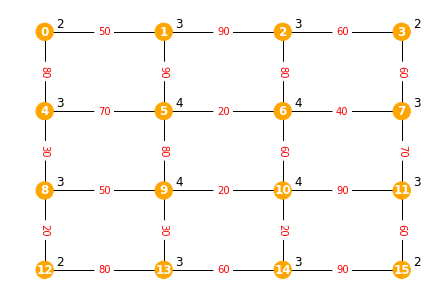

In [155]:
graph.draw()

#### Видалення ребер

In [156]:
graph.delete_edges(9)

14 13
12 8
15 14
6 7
5 6
10 6
8 4
11 7
0 4


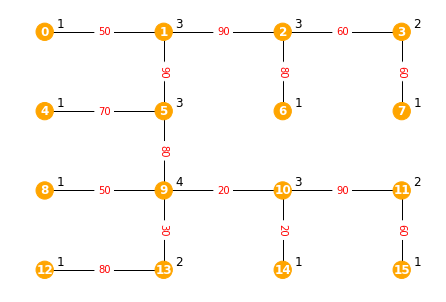

In [157]:
graph.draw() 

#### Тестування проходження шляху

1/1 [==============================] - 0s 18ms/step


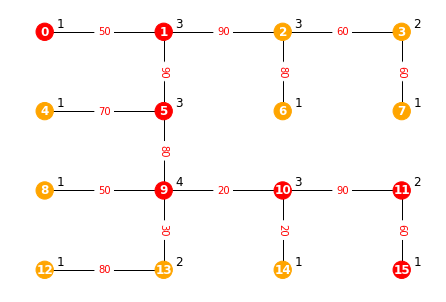

History:  [0, 1, 5, 9, 10, 11, 15]
Speed limitations:  [50, 90, 80, 20, 90, 60]
You have ended the walk


In [158]:
graph.walking(end=15)

1/1 [==============================] - 0s 20ms/step


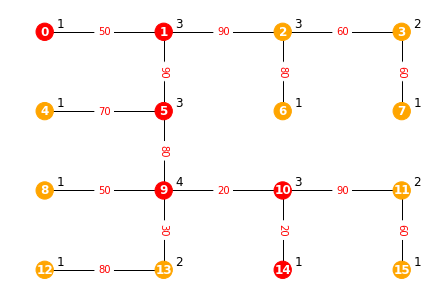

History:  [0, 1, 5, 9, 10, 14]
Speed limitations:  [50, 90, 80, 20, 20]
You have ended the walk


In [159]:
graph.walking(14)

1/1 [==============================] - 0s 21ms/step


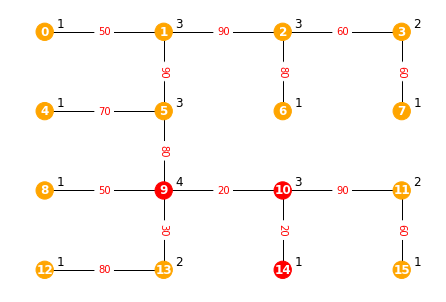

History:  [9, 10, 14]
Speed limitations:  [20, 20]
You have ended the walk


In [160]:
graph.walking(14, 9)

1/1 [==============================] - 0s 19ms/step


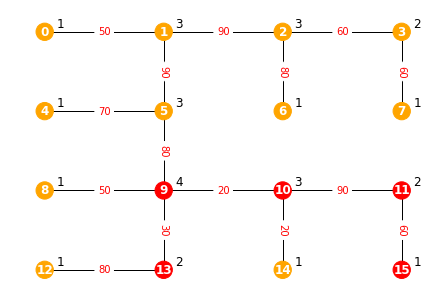

History:  [15, 11, 10, 9, 13]
Speed limitations:  [60, 90, 20, 30]
You have ended the walk


In [161]:
graph.walking(13, 15)

1/1 [==============================] - 0s 21ms/step


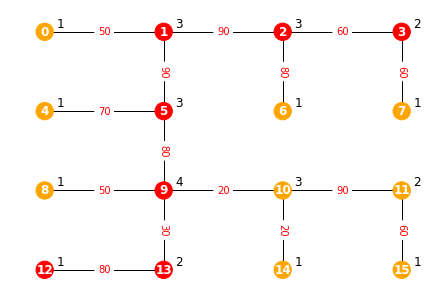

History:  [12, 13, 9, 5, 1, 2, 3]
Speed limitations:  [80, 30, 80, 90, 90, 60]
You have ended the walk


In [162]:
graph.walking(3, 12)

# Висновок

Я на практиці ознайомився із створенням та навчанням згорткової нейронної мережі. Додав до свого алгоритму метод із розпізнаванням рукописних чисел.